## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Будникова|
|---------|--------|
| Группа  | M80-307Б-19      |

Для начала, скачать датасет MNIST, FashionMNIST можно по ссылкам:  
https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz  
https://www.kaggle.com/datasets/zalando-research/fashionmnist


In [18]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pickle
import pandas as pd

In [19]:
with open('Data/mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)

FashionMNIST_file = "Data/fashion-mnist.csv"
FashionMNIST = pd.read_csv(FashionMNIST_file)

Преобразование данных для дальнейшего использования:

In [20]:
MNISTfeatures = MNIST['Train']['Features'] / 255
MNISTlabels = MNIST['Train']['Labels']
MNISTfeatures.astype(np.float32);
MNISTlabels.astype(np.int32);

FashionMNISTlabels = np.array(FashionMNIST['label'].to_list())
FashionMNISTfeatures = FashionMNIST.drop(['label'], axis=1).to_numpy() / 255
FashionMNISTfeatures.astype(np.float32);
FashionMNISTlabels.astype(np.int32);

Просмотр данных

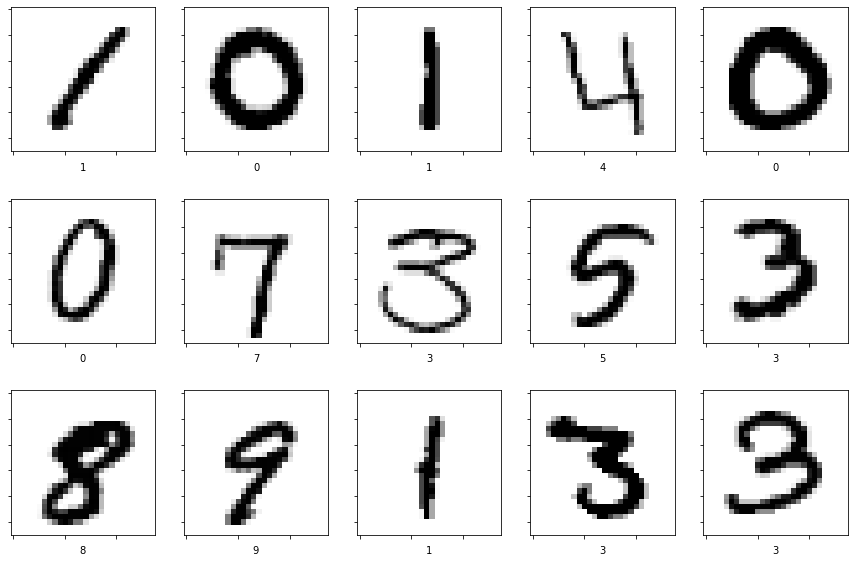

In [21]:
fig = plt.figure(figsize=(15, 10))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(MNISTfeatures[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(MNISTlabels[i])
plt.show()

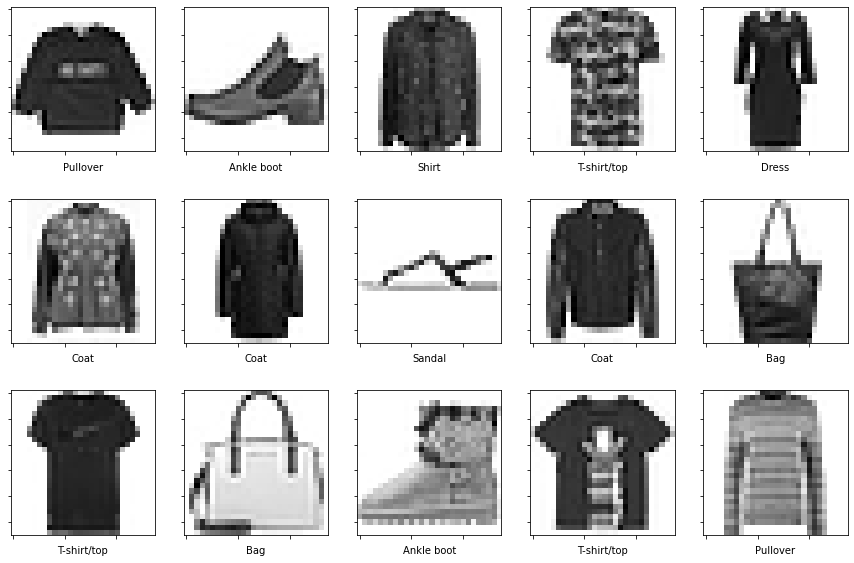

In [22]:
fig = plt.figure(figsize=(15, 10))
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(FashionMNISTfeatures[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(labels[FashionMNISTlabels[i]])
plt.show()

Реализация классов для нейросети:

In [23]:
class Linear:
    def __init__(self, countIn, countOut):
        self.W = np.random.normal(0.1, 1.0 / np.sqrt(countIn), (countIn, countOut))
        self.b = np.zeros((1, countOut))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        self.data = np.zeros_like(self.b)

    def Print(self):
        print(self.W)
        print(self.b)
   
    def Next(self, data):
        self.data = data
        return np.dot(data, self.W) + self.b;

    def Back(self, dz):
        self.dW = np.dot(dz.T, self.data).T
        self.db = dz.sum(axis = 0)
        return np.dot(dz, self.W.T)

    def UpdateWeight(self, speed):
        self.W -= speed * self.dW
        self.b -= speed * self.db

class Softmax:
    def Next(self, z):
        self.z = z
        e = np.exp(z - z.max(axis=1,keepdims=True))
        sum = e.sum(axis=1,keepdims=True)
        self.p = e / sum
        return self.p
    def Back(self, dp):
        back_z = self.p
        return self.p * dp - self.p * (self.p * dp).sum(axis=1, keepdims=True)

class Tanh:
    def Next(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    
    def Back(self, dy):
        return (1.0-self.y**2)*dy

class ReLU:
    def Next(self,x):
        y = np.maximum(0, x)
        self.x = x
        self.y = y
        return y
    
    def Back(self,dy):
        self.x[self.x<=0] = 0
        self.x[self.x>0] = 1
        return self.x * dy

class CrossEntropyLoss:
    def Loss(self, probabilities, trueVal):
        self.p = probabilities;
        self.trueVal = trueVal
        self.size = len(self.trueVal)
        self.loss = [-np.log(probabilities[i, trueVal[i]]) for i in range(self.size)]
        return self.loss
    def Back(self):
        delta = np.zeros_like(self.p)
        delta[np.arange(self.size), self.trueVal] = 1.0
        return delta / (self.p * -self.size)

In [24]:
class Layer:
    def __init__(self, inCount, outCount, speed):
        self.sumFunc = Linear(inCount, outCount)
        self.activation = Softmax()
        self.speed = speed
    
    def SetActivationFunc(self, act):
        self.activation = act

    def Forward(self, data):
        z = self.sumFunc.Next(data)
        p = self.activation.Next(z)
        return p
    
    def Backward(self, dp):
        dz = self.activation.Back(dp)
        dx = self.sumFunc.Back(dz)
        self.sumFunc.UpdateWeight(self.speed)
        return dx
    
    def Test(self, data):
        return self.sumFunc.Next(data)

class Net:
    def __init__(self, countLayers, batchSize, speed,  data, trueValues, accuracy = 0):
        self.countLayers = countLayers
        self.batchSize = batchSize
        self.speed = speed
        self.data = data
        self.train_x, self.test_x = np.split(data, [np.size(trueValues) * 8 // 10])
        self.train_l, self.test_l = np.split(trueValues, [np.size(trueValues) * 8 // 10])
        self.accuracy = accuracy
        self.crossEntropyLoss = CrossEntropyLoss()
        self.loss = []
        self.countNeuron = np.full(self.countLayers, 10)
        self.Activations = []

    def SetCountNeuronInLayers(self, count):
        self.countNeuron = count

    def SetActivationFunctions(self, act):
        self.Activations = act
            
    def MakeLayers(self):
        self.Layers = [Layer(len(self.train_x[0]), self.countNeuron[0], self.speed)]
        if len(self.Activations):
            self.Layers[0].SetActivationFunc(self.Activations[0])
        for i in range(1, self.countLayers):
            self.Layers.append(Layer(self.countNeuron[i - 1], self.countNeuron[i], self.speed))
            if len(self.Activations):
                self.Layers[i].SetActivationFunc(self.Activations[i])

    def Train(self):
        
        self.MakeLayers()
        
        acc = self.Accuracy(self.train_x, self.train_l)
        self.InitialAcc = acc
        
        acc = -1
        self.count = 0
        while (acc < self.accuracy):
            self.count += 1
            rnd = np.random.permutation(len(self.train_l))
            self.train_x = self.train_x[rnd]
            self.train_l = self.train_l[rnd]
            
            for i in range(0, len(self.train_x), self.batchSize):
                x = self.train_x[i : i + self.batchSize]
                l = self.train_l[i : i + self.batchSize]   
                # print(i)
                prev = x
                for layer in self.Layers:
                    prev = layer.Forward(prev)
                # print(prev)

                loss = self.crossEntropyLoss.Loss(prev, l)
                self.loss.append(np.sum(loss) / len(loss))
                prev = self.crossEntropyLoss.Back()

                for layer in reversed(self.Layers):
                    prev = layer.Backward(prev)
                    # print(1)

            acc = self.Accuracy(self.train_x, self.train_l)
        self.FinalAcc = self.Accuracy(self.train_x, self.train_l)
        
   
    def PrintValueTrain(self):
        print("Train")
        print("Initial accuracy: ", self.InitialAcc) 
        print("Final accuracy: ", self.FinalAcc)
    
    def Accuracy(self, x, trueVal):
        pred = x
        for l in self.Layers:
            pred = l.Test(pred)
        pred = np.argmax(pred, axis=1)
        return (pred==trueVal).mean()

    def TestTrue(self, x, trueVal):
        pred = x
        for l in self.Layers:
            pred = l.Test(pred)
        pred = np.argmax(pred, axis=1)

        count = np.zeros(10)
        countTrue = np.zeros(10)
        for i in range(len(trueVal)):
            count[trueVal[i]] += 1
            if trueVal[i] == pred[i]:
                countTrue[trueVal[i]] += 1
        return [count, countTrue]
        
    def PrintValueTest(self):
        print("\nTest accuracy: ", self.Accuracy(self.test_x, self.test_l))

    def TestValue(self):
        return self.Accuracy(self.test_x, self.test_l)

Однослойные персептроны, классифицирующие MNIST и FashionMNIST:

In [25]:
print("\n MNIST:")
net = Net(countLayers=1, batchSize=5, speed=0.5, data=MNISTfeatures, trueValues=MNISTlabels, accuracy=0.86)
net.Train()
net.PrintValueTrain()
print("Количество эпох:" + str(net.count))
net.PrintValueTest()


print("\n FashionMNIST:")
fnet = Net(countLayers=1, batchSize=20, speed=0.1, data=FashionMNISTfeatures, trueValues=FashionMNISTlabels, accuracy=0.85)
fnet.Train()
fnet.PrintValueTrain()
print("Количество эпох:" + str(fnet.count))
fnet.PrintValueTest()



 MNIST:
784
Train
Initial accuracy:  0.09226190476190477
Final accuracy:  0.8799107142857143
Количество эпох:2

Test accuracy:  0.871547619047619

 FashionMNIST:
784
Train
Initial accuracy:  0.07889583333333333
Final accuracy:  0.8520416666666667
Количество эпох:3

Test accuracy:  0.8418333333333333


In [26]:
def PlotEntropyLoss(loss, title):
    y = loss
    x = np.arange(len(y))
    spl = interpolate.UnivariateSpline(x, y, k = 3)
    xx = np.arange(len(y))[::len(y) // 5]
    xx[-1] = len(y)
    # plt.plot(x[::10], y[::10])
    plt.plot(xx, spl(xx), 'r-')
    plt.axis([0, len(x), 0, y[0]])
    plt.title(title)
    plt.ylabel("CrossEntropyLoss", size = 10)
    plt.xlabel("Train", size = 10)
    plt.show()
def Plot(x, y, xLabel, yLabel, title):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xLabel, size = 10)
    plt.ylabel(yLabel, size = 10)
    plt.show()
def Plots(x, y, xLable, yLable, titles, size = 10):
    fig = plt.figure(figsize=(len(titles) * 4, len(titles) * 4))
    for i in range(len(titles)):
        plt.subplot(len(titles) / 4 + 1, 4, i+1)
        plt.plot(x[i], y[i])
        plt.xlabel(xLable, size=size)
        plt.ylabel(yLable, size=size)
        plt.xlabel(titles[i])
    plt.show()

Поведение CrossEntropyLoss при обучении:

In [27]:
PlotEntropyLoss(net.loss, "MINIST (Количество эпох:" + str(net.count) + ")" )
PlotEntropyLoss(fnet.loss, "FashionMINIST (Количество эпох:" + str(fnet.count) + ")")

KeyboardInterrupt: 

In [ ]:
speed = np.arange(0, 2, 0.1)
Accuracy = []
for i in speed:
    testnet = Net(countLayers=1, batchSize=5, speed=i, data=MNISTfeatures, trueValues=MNISTlabels)
    testnet.Train()
    Accuracy.append(testnet.TestValue())
Plot(speed, Accuracy, "speed", "Accuracy", "Зависимость точности от скорости обучениия (MNIST, одна эпоха)")

KeyboardInterrupt: 

<ipython-input-5-da7f140d20c6>:67: RuntimeWarning: invalid value encountered in true_divide
  return delta / (self.p * -self.size)


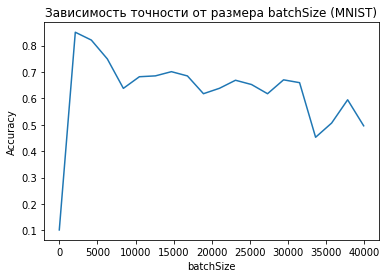

In [ ]:
batchSizes = np.arange(len(MNISTfeatures))[::len(MNISTfeatures) // 20]
batchSizes[0] = 1
Accuracy = []
for i in batchSizes:
    testnet = Net(countLayers=1, batchSize=i, speed=0.001, data=MNISTfeatures, trueValues=MNISTlabels)
    testnet.Train()
    Accuracy.append(testnet.TestValue())
Plot(batchSizes, Accuracy, "batchSize", "Accuracy", "Зависимость точности от размера batchSize (MNIST)")


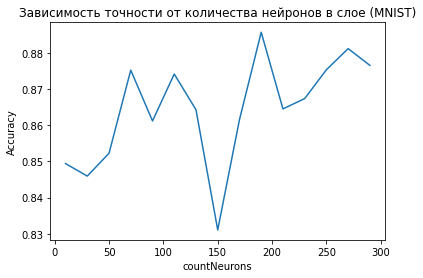

In [ ]:
countNeurons = np.arange(10, 300, 20)
Accuracy = []
for i in countNeurons:
    testnet = Net(countLayers=1, batchSize=5, speed=0.6, data=MNISTfeatures, trueValues=MNISTlabels)
    testnet.SetCountNeuronInLayers([i])
    testnet.Train()
    Accuracy.append(testnet.TestValue())
Plot(countNeurons, Accuracy, "countNeurons", "Accuracy", "Зависимость точности от количества нейронов в слое (MNIST)")


Многослойныe персептрон, классифицирующие MNIST:

In [ ]:
print("\n MNIST:")
net = Net(countLayers=2, batchSize=20, speed=0.001, data=MNISTfeatures, trueValues=MNISTlabels, accuracy=0.86)
net.SetCountNeuronInLayers([180, 10])
net.SetActivationFunctions([ReLU(), Softmax()])
net.Train()
net.PrintValueTrain()
print("Количество эпох:" + str(net.count))
net.PrintValueTest()



 MNIST:
Train
Initial accuracy:  0.0862202380952381
Final accuracy:  0.8627678571428572
Количество эпох:6

Test accuracy:  0.8616666666666667


Сравнение Tanh и ReLU

In [ ]:
testnet1 = Net(countLayers=2, batchSize=20, speed=0.001, data=MNISTfeatures, trueValues=MNISTlabels)
testnet1.SetCountNeuronInLayers([180, 10])
testnet1.SetActivationFunctions([Tanh(), Softmax()])
testnet1.Train()

testnet2 = Net(countLayers=2, batchSize=20, speed=0.001, data=MNISTfeatures, trueValues=MNISTlabels)
testnet2.SetCountNeuronInLayers([180, 10])
testnet2.SetActivationFunctions([ReLU(), Softmax()])
testnet2.Train()


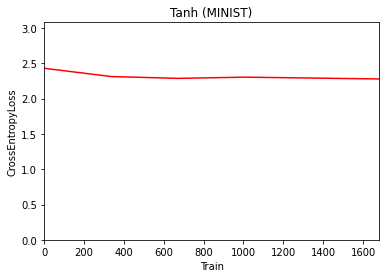

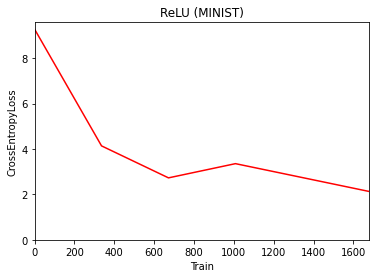

In [ ]:
PlotEntropyLoss(testnet1.loss, "Tanh (MINIST)")
PlotEntropyLoss(testnet2.loss, "ReLU (MINIST)")

Анализ FashionMNIST


 FashionMNIST:
Train
Initial accuracy:  0.059625
Final accuracy:  0.8573125
Количество эпох:5

Test accuracy:  0.84525


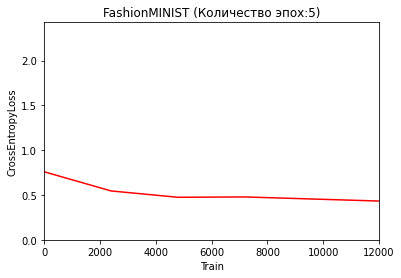

In [ ]:
print("\n FashionMNIST:")
fnet = Net(countLayers=1, batchSize=20, speed=0.1, data=FashionMNISTfeatures, trueValues=FashionMNISTlabels, accuracy=0.85)
fnet.Train()
fnet.PrintValueTrain()
print("Количество эпох:" + str(fnet.count))
fnet.PrintValueTest()

PlotEntropyLoss(fnet.loss, "FashionMINIST (Количество эпох:" + str(fnet.count) + ")")

Из данного графика можно понять, что ошибка хоть и уменьшается, но стремится к нулю не так быстро, как при обучении с помошью MNIST. Это происходит потому, что одежда не так сильно отличается друг от друга, как цифры, в данных размерах картинок. В данном датасете даны очень похожие друг на друга предметы одеждны, что затрудняет обучение  
Постомрим, с какой точностью определяется каждый тип одежды: 

In [ ]:
tr = fnet.TestTrue(FashionMNISTfeatures, FashionMNISTlabels)
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(len(labels)):
    a = (int)((tr[1][i] / tr[0][i]) * 100)
    print(labels[i] + " : " + str(a) + "%")

T-shirt/top : 88%
Trouser : 95%
Pullover : 82%
Dress : 91%
Coat : 71%
Sandal : 93%
Shirt : 50%
Sneaker : 95%
Bag : 93%
Ankle boot : 93%


Анализируя данные, можно прийти к выводу о том, что предметы, которые сильно отличаюся друг от друга распознаются правильно, а похожие (например coat и shirt) распознаются правильно только в 70 и 50 процентах соотвественно. 